# Clustering Geospatial Data

In this tutorial we will learn how to use scikit-learn library to perform clustering on geo-spatial data.

We will use the “Starbucks Stores dataset” that provides the location of all the stores in operation (link below). We shall select a particular geographic area and use the latitude and longitude provided to spatially cluster the Starbucks store locations.

As mentioned there are many clustering algorithms available. We will use the K-Means as an example in this tutorial.

```{Note}

    An end-to-end Scikit-learn workflow for clustering data:
        1. Get the data ready
        2. Choose the right model and hyperparameters
        3. Fit the model to the data and make predictions
        4. Evaluate the model
        5. Improve the model
        6. Save and load a trained model
        7. Put it all together!

```

## Data Preparation

### Setup
First of all, I need to import the following packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for geospatial
import folium

## for machine learning
from sklearn import preprocessing, cluster



Then we have to read the data into a pandas Dataframe.

In [2]:
dtf = pd.read_csv('data_stores.csv')

dtf.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39


The original dataset contains over 5,000 cities and 25,000 stores, but for the purpose of this tutorial, we will work with just one city.

In [3]:
filter = "Calgary"

dtf = dtf[dtf["City"]==filter][["City","Longitude","Latitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id"})

dtf.head()


,id,City,Longitude,Latitude
0,0,Calgary,-114.06,51.05
1,1,Calgary,-114.07,51.04
2,2,Calgary,-114.07,51.05
3,3,Calgary,-114.07,51.05
4,4,Calgary,-114.08,51.05


## Visualization on Map

In [4]:
# visualize all the stores locations on foiium map
f = folium.Figure(width=750, height=750)
map_ = folium.Map(location=[dtf['Latitude'].mean(), dtf['Longitude'].mean()], zoom_start=11, tiles="cartodbpositron").add_to(f)
for i in range(0, dtf.shape[0]):
    folium.Marker([dtf.iloc[i]['Latitude'], dtf.iloc[i]['Longitude']], 
                  popup=dtf.iloc[i]['City']).add_to(map_)
map_

## Clustering Using K-Means

As we mentioned, for k_means we need to define the number of clusters.
for the beggining we just want to perform clustering based on the coordinates with some random number of clusters

In [5]:
# define the number of clusters
n_clusters = 5

# define the kmeans algorithm
kmeans = cluster.KMeans(
    n_clusters=n_clusters, # how many clusters
    init='k-means++', # initialization
    max_iter=300, # maximum number of iterations for each run
    n_init=10, # number of times the k-means algorithm will be run with different centroid seeds
    random_state=0 # the random number generator
    )

#create the X matrix
X = dtf[["Longitude","Latitude"]]

# fit the model
kmeans.fit(X)

# predict add cluster information to the dataframe
dtf['cluster'] = kmeans.predict(X)


# visualize the clusters
f = folium.Figure(width=750, height=750)
map_ = folium.Map(location=[dtf['Latitude'].mean(), dtf['Longitude'].mean()], zoom_start=11, tiles="cartodbpositron").add_to(f)
colors = sns.color_palette("Set2", n_colors=n_clusters).as_hex()
for i in range(0, dtf.shape[0]):
    folium.Circle(
        location=[dtf.iloc[i]['Latitude'], dtf.iloc[i]['Longitude']],
        color=colors[dtf.iloc[i]['cluster']], 
        fill=True,
        fill_color=colors[dtf.iloc[i]['cluster']],
        radius=200).add_to(map_)
map_

## Find the best number of clusters using the elbow method and silhouette score

In this part, instead of random number of clusters, we will use the elbow method and silhouette score to find the best number of clusters. The higher silhouette score means the better clustering. Som we need to find the number of clusters that maximize the silhouette score.
We use a for loop to fit the model with different number of clusters and then we calculate the silhouette score for each model.
then we plot the silhouette score for each model and we choose the number of clusters that gives the highest silhouette score.

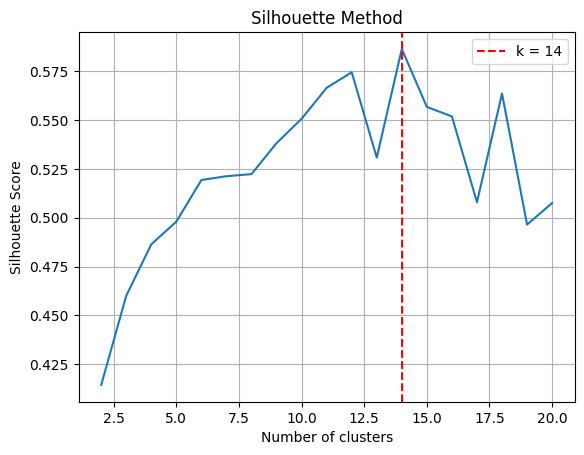

In [6]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

# calculate the silhouette score
sil = []
# define the range of clusters to test
kmax = 20
# fit the model for each number of clusters
for k in range(2, kmax+1):
    kmeans = cluster.KMeans(n_clusters=k).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))


# find the best number of clusters that maximizes the silhouette score
k = np.argmax(sil)+2

# plot the silhouette score
fig, ax = plt.subplots()
plt.plot(range(2, kmax+1), sil)
plt.axvline(k, ls='--', color="red", label="k = "+str(k))
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()


## Use matplotlib to plot all clustering results for all number of clusters

Now that we are using a for loop to find the best number of clusters, we can plot all the clustering results as the same time to get better sense of different clustering results with different number of clusters.

We also use the k-means centroids to see the location of centriod of each cluster

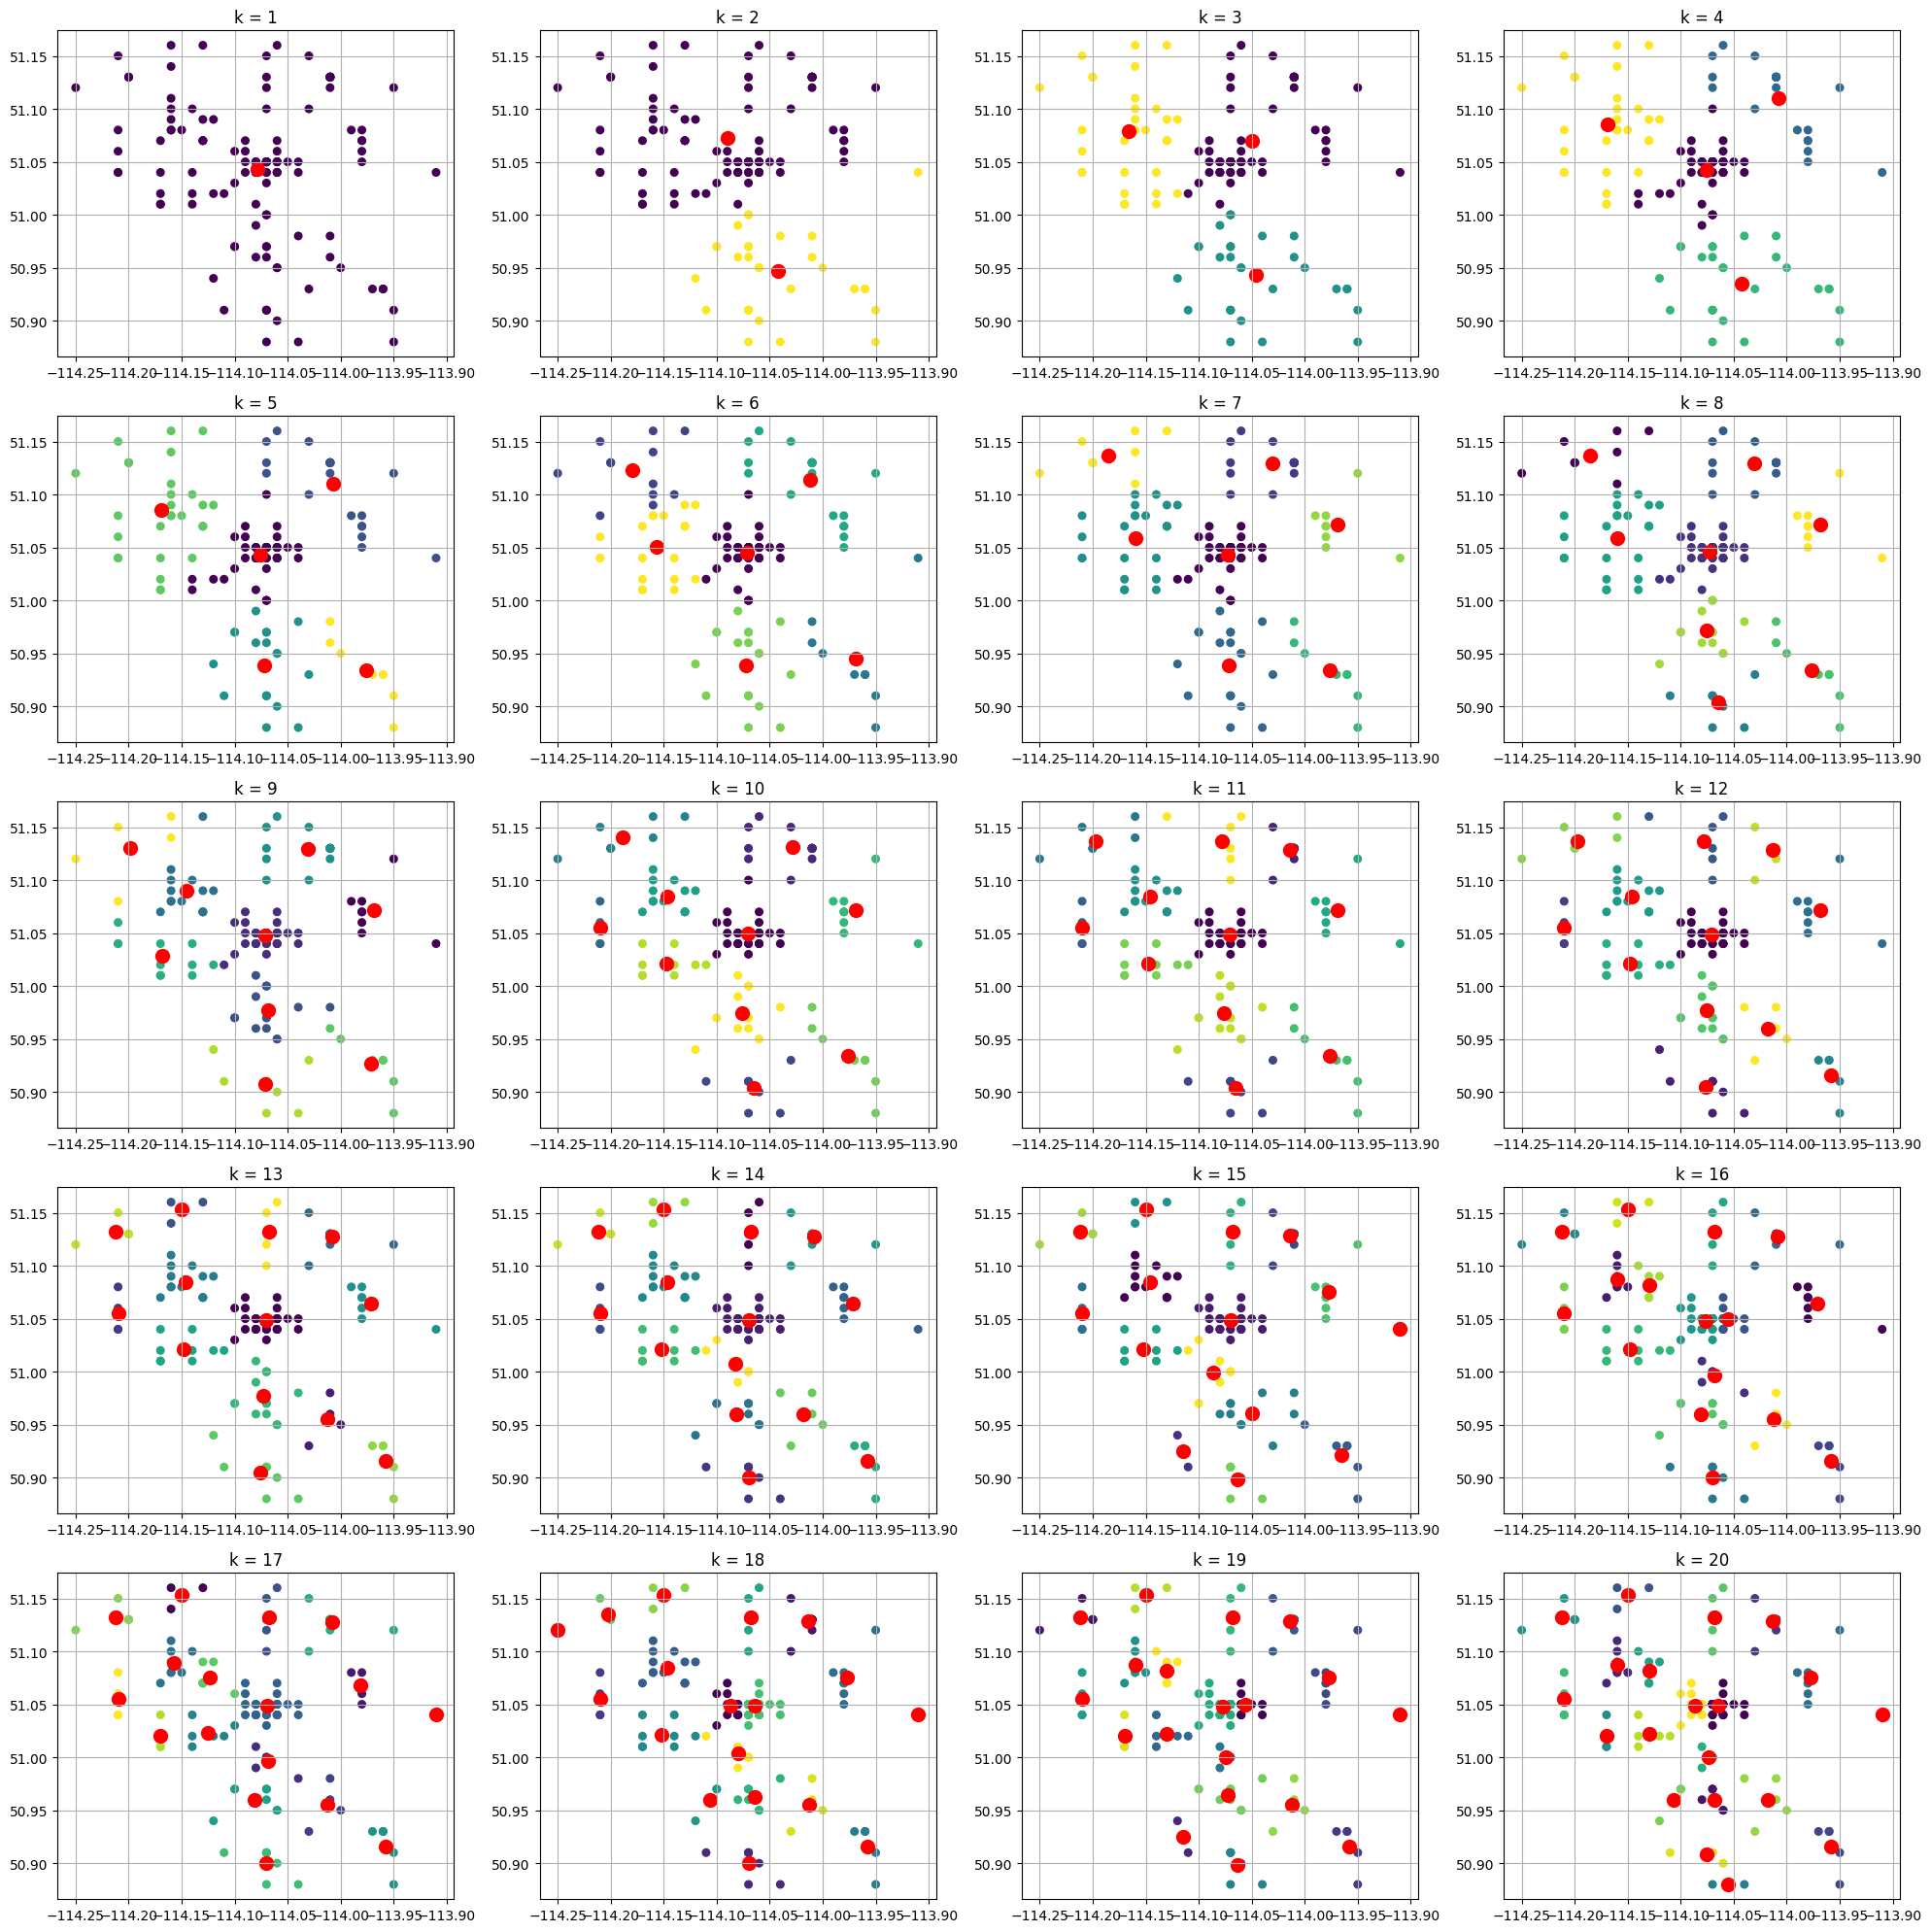

In [7]:
# perform k means clustering from 1 cluster to 20 and plot the results with plt each cluster has same color
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(5, 4, figsize=(20, 20))
ax = ax.ravel()
centers = []
for i in range(1, 21):
    model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    model.fit(X)
    centers.append(model.cluster_centers_)
    y = model.predict(X)
    ax[i-1].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=30, cmap='viridis')
    ax[i-1].scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=100, c='red')
    ax[i-1].set_title('k = '+str(i))
    ax[i-1].grid(True)
plt.tight_layout()
plt.show()

## Plotting the Results on Interactive Map

Now that we know the best number of clusters, we can fit the model and visualize the results on the interactive map
for this purpose, we will use the folium library to create a map and visualize the clusters with different colors and show the centroid of each cluster with a red marker

In [8]:
# do the kmans clustering base on k=12
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

dtf_clustered = dtf.copy()
dtf_clustered["cluster_number_kmeans"] = kmeans.fit_predict(X)

# find the real centroids lat and lon
real_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
real_centroids["cluster_number_kmeans"] = real_centroids.index
real_centroids["Latitude_centroid"] = real_centroids["Latitude"]
real_centroids["Longitude_centroid"] = real_centroids["Longitude"]

# add cluster label and centroids to the restaurants
dtf_clustered = pd.merge(dtf_clustered, real_centroids[["cluster_number_kmeans", "Latitude_centroid", "Longitude_centroid"]], on="cluster_number_kmeans", how="left")

# display the restaurants first 3 rows
dtf_clustered.head(3)

,id,City,Longitude,Latitude,cluster,cluster_number_kmeans,Latitude_centroid,Longitude_centroid
0,0,Calgary,-114.06,51.05,0,0,51.048293,-114.070732
1,1,Calgary,-114.07,51.04,0,0,51.048293,-114.070732
2,2,Calgary,-114.07,51.05,0,0,51.048293,-114.070732


In [9]:
# plot the points on map with folium with their cluster centroids, each cluster members have the same color
f = folium.Figure(width=750, height=750)
map_ = folium.Map(location=[51.0447, -114.0719], tiles='cartodbpositron', zoom_start=10).add_to(f)

# define color list for the clusters based on the number of clusters
color_list = sns.color_palette("Set2", n_colors=n_clusters).as_hex()

for i in range(len(dtf_clustered)):
    location = [dtf_clustered['Latitude'].iloc[i], dtf_clustered['Longitude'].iloc[i]]
    folium.CircleMarker(location, radius=5, color=color_list[int(dtf_clustered['cluster_number_kmeans'].iloc[i])], fill=True, fill_color=color_list[int(dtf_clustered['cluster_number_kmeans'].iloc[i])]).add_to(map_)
    
    
for i in range(len(real_centroids)):
    location = [real_centroids['Latitude_centroid'].iloc[i], real_centroids['Longitude_centroid'].iloc[i]]
    folium.Marker(location, popup="cluster_number_kmeans "+str(real_centroids['cluster_number_kmeans'].iloc[i])).add_to(map_)
    
map_